# Building a model to determine used car values

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, users can quickly find out the market value of your car. We have access to historical data: technical specifications, trim versions, and prices. We will build the model to determine the value.

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# 1. Data preparation

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df = pd.read_csv('/datasets/car_data.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [ ]:
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15
354368,20/03/2016 19:41,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,20/03/2016 00:00,0,40764,24/03/2016 12:45


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [ ]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05/03/2016 14:25,sedan,manual,golf,petrol,volkswagen,no,03/04/2016 00:00,07/04/2016 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654


In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Upon initial inspection of the data, a few things were discovered within the 354,369 entries:
1. `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, and `LastSeen` are irrelevant features for finding out the value of a car, so it is best to drop these columns.
2. `RegistrationYear` and `Power` have a few unusually high values.
3. There are very low values in `RegistrationYear` and `Price`.
4. It would be good to check `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `Brand` for any unusual values.
4. There are '0' values in `RegistrationMonth`, and `Power` worth inspecting.
5. `Model`, `VehicleType`, `Gearbox`, `FuelType`, `NotRepaired` have NA values that should be taken care of.

#### Dropping unnecessary columns

In [ ]:
df.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], inplace=True)

#### Inspecting high values

In [ ]:
df.loc[df['RegistrationYear'] > 2016].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes
57,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no


In [ ]:
df = df.loc[df['RegistrationYear'] <= 2016]

The data is from the year 2016, so it is impossible for a car's registration year to be later than 2016. It is best to drop these rows from the dataset altogether, since it is difficult to accurately estimate the correct registration year.

In [ ]:
df.loc[df['Power'] > 1499]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
2102,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN
9664,2599,NaN,2016,manual,1779,zafira,150000,0,petrol,opel,no
9875,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes
11039,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no
...,...,...,...,...,...,...,...,...,...,...,...
348006,355,sedan,1998,manual,1799,vectra,150000,6,petrol,opel,NaN
348137,850,sedan,1993,auto,9012,golf,150000,0,petrol,volkswagen,NaN
348237,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes
348668,1000,wagon,1996,manual,2598,a6,150000,7,NaN,audi,NaN


In [ ]:
df = df.loc[df['Power'] <= 1499]

A Google search reveals that the highest available horsepower for a car in 2016 was 1,499. Values greater than 1,499 signal inaccurate data and only represent 0.0005 of the total dataset, so  these rows are dropped instead of replacing them with an estimate.

#### Inspecting low values in `RegistrationYear` and `Price`

In [ ]:
df.loc[df['RegistrationYear'] < 1960]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN
1928,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no
2273,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no
3333,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN
...,...,...,...,...,...,...,...,...,...,...,...
351299,5500,bus,1956,manual,37,NaN,60000,4,petrol,sonstige_autos,no
351682,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN
353531,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN
353961,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN


In [ ]:
df = df.loc[df['RegistrationYear'] > 1960]

0.001 of the dataset has a recorded registration year earlier than 1960. These records may be due to an error or may actually indicate antique cars. It is unlikely for a used car older than 60 years old to go on the market in comparison with more current cars, so these records will also be dropped.

In [ ]:
df.loc[df['Price'] <= 100].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no
115,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN


In [ ]:
df = df.loc[df['Price'] > 100]

Entries with the value 100 or lower in `Price` will be dropped. It is unlikely for a user to put their car on sale for such a low price. Price is the target variable here so dropping the rows will help avoid any potential skewing.

#### Checking `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `Brand` for unusual values

In [ ]:
df['VehicleType'].value_counts()

sedan          88788
small          76963
wagon          63328
bus            28234
convertible    19773
coupe          15503
suv            11720
other           2998
Name: VehicleType, dtype: int64

In [ ]:
df['Gearbox'].value_counts()

manual    248818
auto       62699
Name: Gearbox, dtype: int64

In [ ]:
df['Model'].value_counts()

golf                  26476
other                 22744
3er                   18549
polo                  11817
corsa                 11327
                      ...  
serie_2                   6
serie_3                   3
rangerover                3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

In [ ]:
df['FuelType'].value_counts()

petrol      202588
gasoline     94545
lpg           5009
cng            527
hybrid         219
other          146
electric        85
Name: FuelType, dtype: int64

In [ ]:
df['Brand'].value_counts()

volkswagen        70051
opel              36091
bmw               34461
mercedes_benz     30150
audi              27458
ford              23060
renault           16169
peugeot           10316
fiat               8733
seat               6288
skoda              5280
mazda              5208
smart              4940
citroen            4728
nissan             4572
toyota             4382
hyundai            3379
mini               3049
volvo              3024
mitsubishi         2785
honda              2574
sonstige_autos     2439
kia                2290
suzuki             2173
alfa_romeo         2122
chevrolet          1635
chrysler           1304
dacia               863
daihatsu            727
subaru              701
porsche             691
jeep                617
land_rover          525
saab                501
daewoo              492
jaguar              481
trabant             445
rover               427
lancia              425
lada                206
Name: Brand, dtype: int64

#### Inspecting '0' values in `RegistrationMonth` and `Power`

In [ ]:
df.loc[df['RegistrationMonth'] == 0].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no


In [ ]:
df = df.loc[df['RegistrationMonth'] > 0]

The correct range for `RegistrationMonth` only spans the values 1 to 12. It is difficult to accurately estimate the correct registration month, so entries with a `RegistrationMonth` of 0 will be dropped.

In [ ]:
df.loc[df['Power'] == 0].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes
70,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no
90,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN


In [ ]:
df = df.loc[df['Power'] > 0]

Since the data comprises a large set of years and horsepower has increased a lot over time, it is hard to accurately estimate what the corect horsepower is for these entries. These rows will be dropped.

#### Investigating NA values in `Model`, `VehicleType`, `Gearbox`, `FuelType`, and `NotRepaired`

In [ ]:
df.loc[df['Model'].isna()].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes
151,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no
161,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN
273,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no


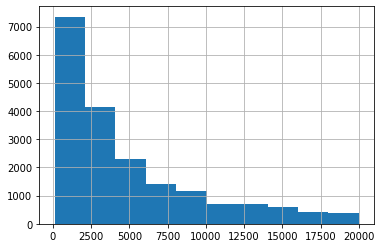

In [ ]:
df.loc[df['Model'] == 'other', 'Price'].hist()

In [ ]:
df.groupby('Model')['Price'].median()

Model
100         1300.0
145          750.0
147         2000.0
156         1350.0
159         6500.0
            ...   
yaris       3500.0
yeti       12990.0
ypsilon      999.0
z_reihe     9900.0
zafira      3299.0
Name: Price, Length: 249, dtype: float64

In [ ]:
df.dropna(subset=['Model'], inplace=True)

In [ ]:
df = df.loc[df['Model'] != 'other']

At first I considered grouping NA values in `Model` into the 'other' category. However, after realizing that the model greatly influences the final price of a car, I figured it may be best to drop the rows containing NA and 'other' that are in the `Model` column instead. 

In [ ]:
df.loc[df['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN
35,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no
71,2300,NaN,1997,manual,150,5er,150000,3,NaN,bmw,no
77,800,NaN,2000,manual,90,golf,150000,2,gasoline,volkswagen,NaN
79,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
354049,350,NaN,2000,manual,50,ibiza,150000,5,NaN,seat,no
354068,3700,NaN,2016,manual,90,golf,150000,4,gasoline,volkswagen,NaN
354107,395,NaN,2016,manual,60,golf,150000,12,petrol,volkswagen,NaN
354115,299,NaN,2016,manual,60,astra,150000,4,petrol,opel,yes


In [ ]:
df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x:x.value_counts().index[0]), inplace=True)

NA values in `VehicleType` are replaced with the mode of each respective car model since the vehicle type typically stays constant with the car model.

In [ ]:
df.loc[df['Gearbox'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
208,2250,small,2001,NaN,41,fortwo,150000,10,gasoline,smart,no
276,2400,convertible,2001,NaN,115,golf,150000,8,petrol,volkswagen,no
294,2390,small,2016,NaN,83,jazz,150000,12,petrol,honda,no
296,1699,sedan,1999,NaN,75,astra,150000,12,petrol,opel,NaN
359,6250,sedan,2003,NaN,299,a6,150000,3,petrol,audi,NaN
...,...,...,...,...,...,...,...,...,...,...,...
353422,2450,sedan,1998,NaN,75,golf,90000,8,petrol,volkswagen,NaN
353552,11950,bus,2012,NaN,109,kangoo,90000,8,gasoline,renault,no
353664,2350,sedan,2002,NaN,75,golf,125000,6,NaN,volkswagen,NaN
354133,250,small,1994,NaN,75,golf,150000,6,petrol,volkswagen,no


In [ ]:
df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x:x.value_counts().index[0]), inplace=True)

Likewise, NA values in `Gearbox` are replaced with the mode of each respective car model since the gearbox type typically stays constant with the car model.

In [ ]:
df.loc[df['FuelType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN
71,2300,sedan,1997,manual,150,5er,150000,3,NaN,bmw,no
96,6450,bus,2008,manual,84,transporter,150000,12,NaN,volkswagen,no
119,400,sedan,2000,manual,144,omega,150000,10,NaN,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
354236,1799,wagon,2005,manual,180,signum,150000,1,NaN,opel,yes
354265,3000,sedan,2001,auto,150,a4,150000,8,NaN,audi,yes
354327,2999,wagon,2004,manual,234,vectra,100000,1,NaN,opel,NaN
354339,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no


In [ ]:
df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x:x.value_counts().index[0]), inplace=True)

NA values in `FuelType` are also replaced with the mode of each respective car model since the fuel type typically stays constant with the car model.

In [ ]:
df.loc[df['NotRepaired'].isna()].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
12,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN
31,899,small,2016,manual,60,clio,150000,6,petrol,renault,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,4,gasoline,mercedes_benz,NaN


In [ ]:
df['NotRepaired'].value_counts()

no     197728
yes     22174
Name: NotRepaired, dtype: int64

In [ ]:
df['NotRepaired'].fillna('no', inplace=True)

NA values in `NotRepaired` are replaced with the value 'no', which is the most commonly used value throughout the dataset.

#### Finding and dropping duplicates

In [ ]:
df.duplicated().sum()

24840

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224350 entries, 0 to 224349
Data columns (total 11 columns):
Price                224350 non-null int64
VehicleType          224350 non-null object
RegistrationYear     224350 non-null int64
Gearbox              224350 non-null object
Power                224350 non-null int64
Model                224350 non-null object
Mileage              224350 non-null int64
RegistrationMonth    224350 non-null int64
FuelType             224350 non-null object
Brand                224350 non-null object
NotRepaired          224350 non-null object
dtypes: int64(5), object(6)
memory usage: 18.8+ MB


224,350 entries remain after removing potential erroneous data such as outliers and duplicates.

#### Transform categorical features into category datatype for `LightBGM` and `CatBoost`

In [ ]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for col in cat_features:
    df[col] = df[col].astype('category')

#### Create feature and target variables

In [ ]:
target = df['Price']
features = df.drop(['Price'], axis=1)

#### Transforming categorical features into numerical features using OHE

In [ ]:
features_ohe = pd.get_dummies(features, drop_first=True)

#### Split the data into a 3:1:1 ratio after OHE

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features_ohe, target, test_size=0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, shuffle = False)

In [ ]:
print("--- Train Sizes (Rows, Columns) ---")
print("target_train:", target_train.shape)
print("features_train:", features_train.shape)
print("")
print("--- Valid Sizes (Rows, Columns) ---")
print("target_valid:", target_valid.shape)
print("features_valid:", features_valid.shape)
print("")
print("--- Test Sizes (Rows, Columns) ---")
print("target_test:", target_test.shape)
print("features_test:", features_test.shape)

--- Train Sizes (Rows, Columns) ---
target_train: (134610,)
features_train: (134610, 304)

--- Valid Sizes (Rows, Columns) ---
target_valid: (44870,)
features_valid: (44870, 304)

--- Test Sizes (Rows, Columns) ---
target_test: (44870,)
features_test: (44870, 304)


#### Split the data into a 3:1:1 ratio without OHE

In [ ]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features, target, test_size=0.4, random_state = 12345)
features_valid_2, features_test_2, target_valid_2, target_test_2 = train_test_split(features_valid_2, target_valid_2, test_size=0.5, shuffle = False)

In [ ]:
print("--- Train Sizes (Rows, Columns) ---")
print("target_train:", target_train_2.shape)
print("features_train:", features_train_2.shape)
print("")
print("--- Valid Sizes (Rows, Columns) ---")
print("target_valid:", target_valid_2.shape)
print("features_valid:", features_valid_2.shape)
print("")
print("--- Test Sizes (Rows, Columns) ---")
print("target_test:", target_test_2.shape)
print("features_test:", features_test_2.shape)

--- Train Sizes (Rows, Columns) ---
target_train: (134610,)
features_train: (134610, 10)

--- Valid Sizes (Rows, Columns) ---
target_valid: (44870,)
features_valid: (44870, 10)

--- Test Sizes (Rows, Columns) ---
target_test: (44870,)
features_test: (44870, 10)


# 2. Model training

In [ ]:
def find_rmse(target_test, predictions):
    return round(mean_squared_error(target_test, predictions) ** 0.5, 2)

In [ ]:
rmse = make_scorer(find_rmse, greater_is_better=False)

### Comparing models with default hyperparameters

#### Linear Regression

In [ ]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predicted_valid = lr_model.predict(features_valid)
rmse_calc = mean_squared_error(target_valid, predicted_valid)**0.5
print('RMSE:', rmse_calc)

RMSE: 2497.581152617857
CPU times: user 10.6 s, sys: 4.57 s, total: 15.1 s
Wall time: 15.4 s


#### Random Forest Regressor

In [ ]:
%%time
rf_model = RandomForestRegressor(random_state=99)
rf_model.fit(features_train, target_train)
predicted_valid = rf_model.predict(features_valid)
rmse_calc = mean_squared_error(target_valid, predicted_valid)**0.5
print('RMSE:', rmse_calc)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1614.1344317562598
CPU times: user 32.5 s, sys: 0 ns, total: 32.5 s
Wall time: 33.2 s


#### LightGBM with initial one hot encoding

In [ ]:
%%time
lg_model = lgb.LGBMRegressor(random_state=99)
lg_model.fit(features_train, target_train)
predicted_valid = lg_model.predict(features_valid)
rmse_calc = mean_squared_error(target_valid, predicted_valid)**0.5
print('RMSE:', rmse_calc)

RMSE: 1561.154894008287
CPU times: user 9.18 s, sys: 280 ms, total: 9.46 s
Wall time: 9.57 s


#### LightGBM without initial one hot encoding

In [ ]:
%%time
lg_model_2 = lgb.LGBMRegressor(random_state=99)
lg_model_2.fit(features_train_2, target_train_2, categorical_feature=cat_features)
predicted_valid = lg_model_2.predict(features_valid_2)
rmse_calc = mean_squared_error(target_valid_2, predicted_valid)**0.5
print('RMSE:', rmse_calc)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE: 1503.8298597073103
CPU times: user 6.49 s, sys: 48.6 ms, total: 6.53 s
Wall time: 6.6 s


#### CatBoost with initial one hot encoding

In [ ]:
%%time
cb_model = CatBoostRegressor(random_state=99)
cb_model.fit(features_train, target_train)
predicted_valid = cb_model.predict(features_valid)
rmse_calc = mean_squared_error(target_valid, predicted_valid)**0.5
print('RMSE:', rmse_calc)

0:	learn: 4577.3486915	total: 133ms	remaining: 2m 13s
1:	learn: 4485.9711987	total: 238ms	remaining: 1m 58s
2:	learn: 4396.9620693	total: 340ms	remaining: 1m 53s
3:	learn: 4310.0684861	total: 527ms	remaining: 2m 11s
4:	learn: 4227.6808825	total: 630ms	remaining: 2m 5s
5:	learn: 4147.9136865	total: 731ms	remaining: 2m 1s
6:	learn: 4071.5957512	total: 841ms	remaining: 1m 59s
7:	learn: 3996.8471174	total: 941ms	remaining: 1m 56s
8:	learn: 3925.7609528	total: 1.12s	remaining: 2m 3s
9:	learn: 3856.4163822	total: 1.23s	remaining: 2m 1s
10:	learn: 3788.8081274	total: 1.33s	remaining: 1m 59s
11:	learn: 3723.0290161	total: 1.43s	remaining: 1m 57s
12:	learn: 3659.2700230	total: 1.53s	remaining: 1m 56s
13:	learn: 3599.3144172	total: 1.72s	remaining: 2m 1s
14:	learn: 3541.0856653	total: 1.82s	remaining: 1m 59s
15:	learn: 3484.3394716	total: 1.92s	remaining: 1m 58s
16:	learn: 3431.0492119	total: 2.02s	remaining: 1m 57s
17:	learn: 3379.7274378	total: 2.13s	remaining: 1m 55s
18:	learn: 3330.2319537	t

#### CatBoost without initial one hot encoding

In [ ]:
%%time
cb_model = CatBoostRegressor(random_state=99)
cb_model.fit(features_train_2, target_train_2, cat_features=cat_features)
predicted_valid = cb_model.predict(features_valid_2)
rmse_calc = mean_squared_error(target_valid_2, predicted_valid)**0.5
print('RMSE:', rmse_calc)

0:	learn: 4576.3131949	total: 338ms	remaining: 5m 37s
1:	learn: 4483.6564165	total: 833ms	remaining: 6m 55s
2:	learn: 4394.4235236	total: 1.33s	remaining: 7m 22s
3:	learn: 4307.9541744	total: 1.73s	remaining: 7m 11s
4:	learn: 4227.1169529	total: 2.13s	remaining: 7m 4s
5:	learn: 4148.0864378	total: 2.52s	remaining: 6m 58s
6:	learn: 4069.7943117	total: 2.93s	remaining: 6m 55s
7:	learn: 3994.4054626	total: 3.33s	remaining: 6m 53s
8:	learn: 3921.2597751	total: 3.73s	remaining: 6m 50s
9:	learn: 3853.4087341	total: 4.13s	remaining: 6m 48s
10:	learn: 3783.5324330	total: 4.53s	remaining: 6m 46s
11:	learn: 3720.1716103	total: 4.92s	remaining: 6m 45s
12:	learn: 3657.0623714	total: 5.23s	remaining: 6m 37s
13:	learn: 3595.7672409	total: 5.72s	remaining: 6m 42s
14:	learn: 3536.1252430	total: 6.12s	remaining: 6m 41s
15:	learn: 3478.9626063	total: 6.43s	remaining: 6m 35s
16:	learn: 3423.6948806	total: 6.82s	remaining: 6m 34s
17:	learn: 3371.4526912	total: 7.22s	remaining: 6m 33s
18:	learn: 3321.13660

In this section, I compared the RMSE of 6 models with each other using default hyperparameters:
1. `LinearRegression` - RMSE: 2497.58, Time: 15.4 seconds
2. `RandomForestRegressor` - RMSE: 1613.13, Time: 33.2 seconds
3. `LightGBM` with initial one hot encoding - RMSE: 1561.15, Time: 9.57 seconds
4. `LightGBM` without initial one hot encoding - RMSE: 1503.83, Time: 6.6 seconds
5. `CatBoost` with initial one hot encoding - RMSE: 1561.50, Time: 1 minute 59 seconds
6. `CatBoost` without initial one hot encoding - RMSE: 1542.30, Time: 6 minutes 17 seconds

The `LightGBM` model without initial one hot encoding performed the best, with a final RMSE of 1503.83. It ran at a fast speed with a time of 6.6 seconds, compared to the `CatBoost` models which took more than double the time.

Now that there is a general overview of the models, we can now delve a bit deeper.

### Tuning hyperparameters for each model with cross-validation

#### Random Forest Regressor

In [ ]:
%%time
rf_model = RandomForestRegressor(random_state=99)
params = { 'n_estimators': range(10, 30, 5) }

best_model = RandomizedSearchCV(rf_model, params, scoring=rmse, cv=5, verbose=10)
best_model.fit(features_train, target_train)  
print('Best parameters:', best_model.best_params_)

predictions = best_model.best_estimator_.predict(features_valid)
print('RMSE:', round(mean_squared_error(target_valid, predictions) ** 0.5, 2))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=10 .................................................


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. n_estimators=10, score=-1654.650, total=  25.3s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.3s remaining:    0.0s


[CV] ................. n_estimators=10, score=-1685.940, total=  25.7s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.9s remaining:    0.0s


[CV] ................. n_estimators=10, score=-1636.840, total=  25.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] ................. n_estimators=10, score=-1675.980, total=  27.1s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV] ................. n_estimators=10, score=-1683.080, total=  28.1s
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s


[CV] ................. n_estimators=15, score=-1638.480, total=  40.5s
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.9min remaining:    0.0s


[CV] ................. n_estimators=15, score=-1668.160, total=  40.3s
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.5min remaining:    0.0s


[CV] ................. n_estimators=15, score=-1611.710, total=  39.6s
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.2min remaining:    0.0s


[CV] ................. n_estimators=15, score=-1657.650, total=  41.2s
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.9min remaining:    0.0s


[CV] ................. n_estimators=15, score=-1665.010, total=  40.4s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-1624.630, total=  50.2s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-1657.070, total=  55.7s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-1603.930, total= 1.0min
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-1651.180, total=  56.5s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-1652.200, total=  53.0s
[CV] n_estimators=25 .................................................
[CV] ................. n_estimators=25, score=-1618.720, total= 1.2min
[CV] n_estimators=25 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 16.1min finished


Best parameters: {'n_estimators': 25}
RMSE: 1590.05
CPU times: user 17min 18s, sys: 1.52 s, total: 17min 20s
Wall time: 17min 36s


#### LightGBM with initial one hot encoding

In [ ]:
%%time
lg_model = lgb.LGBMRegressor(random_state=99)
params = { 'n_estimators': range(10, 30, 5), 'learning_rate': [.25, .5, .75] }

best_model = RandomizedSearchCV(lg_model, params, scoring=rmse, cv=5, verbose=10)
best_model.fit(features_train, target_train)  
print('Best parameters:', best_model.best_params_)

predictions = best_model.best_estimator_.predict(features_valid)
print('RMSE:', round(mean_squared_error(target_valid, predictions) ** 0.5, 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=15, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=15, learning_rate=0.75, score=-1677.930, total= 1.1min
[CV] n_estimators=15, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.75, score=-1696.110, total=  41.4s
[CV] n_estimators=15, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.75, score=-1664.640, total= 1.2min
[CV] n_estimators=15, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.75, score=-1686.440, total= 1.4min
[CV] n_estimators=15, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.3min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.75, score=-1696.190, total= 1.2min
[CV] n_estimators=15, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.5, score=-1667.910, total=  16.0s
[CV] n_estimators=15, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.8min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.5, score=-1681.740, total=  38.9s
[CV] n_estimators=15, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.4min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.5, score=-1653.030, total=  18.9s
[CV] n_estimators=15, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.8min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.5, score=-1668.220, total=   3.1s
[CV] n_estimators=15, learning_rate=0.5 ..............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.8min remaining:    0.0s


[CV]  n_estimators=15, learning_rate=0.5, score=-1693.550, total=   3.6s
[CV] n_estimators=25, learning_rate=0.25 .............................
[CV]  n_estimators=25, learning_rate=0.25, score=-1647.340, total=   3.3s
[CV] n_estimators=25, learning_rate=0.25 .............................
[CV]  n_estimators=25, learning_rate=0.25, score=-1674.680, total=   3.4s
[CV] n_estimators=25, learning_rate=0.25 .............................
[CV]  n_estimators=25, learning_rate=0.25, score=-1628.500, total=   5.5s
[CV] n_estimators=25, learning_rate=0.25 .............................
[CV]  n_estimators=25, learning_rate=0.25, score=-1644.470, total=   3.7s
[CV] n_estimators=25, learning_rate=0.25 .............................
[CV]  n_estimators=25, learning_rate=0.25, score=-1658.180, total= 2.1min
[CV] n_estimators=20, learning_rate=0.5 ..............................
[CV]  n_estimators=20, learning_rate=0.5, score=-1645.800, total= 1.6min
[CV] n_estimators=20, learning_rate=0.5 ..................

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 20.6min finished


Best parameters: {'n_estimators': 25, 'learning_rate': 0.5}
RMSE: 1588.33
CPU times: user 20min 10s, sys: 16.9 s, total: 20min 27s
Wall time: 20min 37s


#### LightGBM without initial one hot encoding

In [ ]:
%%time
lg_model_2 = lgb.LGBMRegressor(random_state=99)
params = { 'n_estimators': range(10, 30, 5), 'learning_rate': [.25, .5, .75] }

best_model = RandomizedSearchCV(lg_model_2, params, scoring=rmse, cv=5, verbose=10)
best_model.fit(features_train_2, target_train_2, categorical_feature=cat_features)  
print('Best parameters:', best_model.best_params_)

predictions = best_model.best_estimator_.predict(features_valid_2)
print('RMSE:', round(mean_squared_error(target_valid_2, predictions) ** 0.5, 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=20, learning_rate=0.25 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.25, score=-1587.490, total=   1.5s
[CV] n_estimators=20, learning_rate=0.25 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.25, score=-1621.910, total=   1.5s
[CV] n_estimators=20, learning_rate=0.25 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.25, score=-1571.860, total=   1.5s
[CV] n_estimators=20, learning_rate=0.25 .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.25, score=-1595.320, total=   1.6s
[CV] n_estimators=20, learning_rate=0.25 .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.25, score=-1612.120, total=   1.7s
[CV] n_estimators=20, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.75, score=-1623.880, total=   1.4s
[CV] n_estimators=20, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.2s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.75, score=-1653.060, total=   1.4s
[CV] n_estimators=20, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.6s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.75, score=-1635.030, total=   1.4s
[CV] n_estimators=20, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.0s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.75, score=-1630.560, total=   1.7s
[CV] n_estimators=20, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.8s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.75, score=-1648.330, total=   1.6s
[CV] n_estimators=15, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.5, score=-1605.510, total=   1.2s
[CV] n_estimators=15, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.5, score=-1644.880, total=   1.2s
[CV] n_estimators=15, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.5, score=-1609.570, total=   1.3s
[CV] n_estimators=15, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.5, score=-1628.170, total=   1.2s
[CV] n_estimators=15, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.5, score=-1637.790, total=   1.2s
[CV] n_estimators=10, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.75, score=-1677.830, total=   1.1s
[CV] n_estimators=10, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.75, score=-1711.490, total=   1.0s
[CV] n_estimators=10, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.75, score=-1686.780, total=   1.1s
[CV] n_estimators=10, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.75, score=-1683.550, total=   1.0s
[CV] n_estimators=10, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.75, score=-1699.210, total=   1.2s
[CV] n_estimators=20, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.5, score=-1592.980, total=   5.0s
[CV] n_estimators=20, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.5, score=-1624.340, total=   1.6s
[CV] n_estimators=20, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.5, score=-1597.630, total=   1.5s
[CV] n_estimators=20, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.5, score=-1610.610, total=   1.5s
[CV] n_estimators=20, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=20, learning_rate=0.5, score=-1624.470, total=   1.5s
[CV] n_estimators=25, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=25, learning_rate=0.75, score=-1619.190, total=   1.7s
[CV] n_estimators=25, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=25, learning_rate=0.75, score=-1643.890, total=   1.5s
[CV] n_estimators=25, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=25, learning_rate=0.75, score=-1622.870, total=   1.6s
[CV] n_estimators=25, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=25, learning_rate=0.75, score=-1619.110, total=   1.7s
[CV] n_estimators=25, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=25, learning_rate=0.75, score=-1643.010, total=   1.8s
[CV] n_estimators=10, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.5, score=-1642.430, total=   1.0s
[CV] n_estimators=10, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.5, score=-1676.770, total=   1.1s
[CV] n_estimators=10, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.5, score=-1635.250, total=   1.1s
[CV] n_estimators=10, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.5, score=-1651.580, total=   1.2s
[CV] n_estimators=10, learning_rate=0.5 ..............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.5, score=-1671.310, total=   1.4s
[CV] n_estimators=15, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.75, score=-1643.170, total=   1.4s
[CV] n_estimators=15, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.75, score=-1671.410, total=   1.1s
[CV] n_estimators=15, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.75, score=-1660.730, total=   1.1s
[CV] n_estimators=15, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.75, score=-1646.840, total=   1.3s
[CV] n_estimators=15, learning_rate=0.75 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.75, score=-1667.090, total=   1.4s
[CV] n_estimators=15, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.25, score=-1620.210, total=   1.6s
[CV] n_estimators=15, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.25, score=-1651.570, total=   1.3s
[CV] n_estimators=15, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.25, score=-1603.980, total=   1.4s
[CV] n_estimators=15, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.25, score=-1627.040, total=   1.3s
[CV] n_estimators=15, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=15, learning_rate=0.25, score=-1643.300, total=   3.5s
[CV] n_estimators=10, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.25, score=-1720.060, total=   1.1s
[CV] n_estimators=10, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.25, score=-1745.050, total=   1.0s
[CV] n_estimators=10, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.25, score=-1694.410, total=   1.1s
[CV] n_estimators=10, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.25, score=-1725.550, total=   1.0s
[CV] n_estimators=10, learning_rate=0.25 .............................


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[CV]  n_estimators=10, learning_rate=0.25, score=-1740.760, total=   1.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Best parameters: {'n_estimators': 20, 'learning_rate': 0.25}
RMSE: 1561.9
CPU times: user 1min 13s, sys: 492 ms, total: 1min 13s
Wall time: 1min 15s


#### CatBoost with initial one hot encoding 

In [ ]:
%%time
cb_model = CatBoostRegressor(random_state=99)
params = { 'n_estimators': range(10, 30, 5), 'learning_rate': [.25, .5, .75] }

best_model = RandomizedSearchCV(cb_model, params, scoring=rmse, cv=5, verbose=10)
best_model.fit(features_train, target_train)  
print('Best parameters:', best_model.best_params_)

predictions = best_model.best_estimator_.predict(features_valid)
print('RMSE:', round(mean_squared_error(target_valid, predictions) ** 0.5, 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=20, learning_rate=0.25 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 3923.1865695	total: 44ms	remaining: 835ms
1:	learn: 3387.1045037	total: 143ms	remaining: 1.29s
2:	learn: 2995.6753517	total: 242ms	remaining: 1.37s
3:	learn: 2700.1490298	total: 344ms	remaining: 1.37s
4:	learn: 2496.1499182	total: 444ms	remaining: 1.33s
5:	learn: 2354.5061853	total: 542ms	remaining: 1.26s
6:	learn: 2249.6722711	total: 643ms	remaining: 1.19s
7:	learn: 2168.1253716	total: 743ms	remaining: 1.11s
8:	learn: 2112.2331997	total: 842ms	remaining: 1.03s
9:	learn: 2060.5646890	total: 945ms	remaining: 945ms
10:	learn: 2018.6857742	total: 1.04s	remaining: 853ms
11:	learn: 1975.2674754	total: 1.14s	remaining: 762ms
12:	learn: 1946.6097170	total: 1.24s	remaining: 668ms
13:	learn: 1923.2576554	total: 1.34s	remaining: 575ms
14:	learn: 1899.8622557	total: 1.44s	remaining: 480ms
15:	learn: 1883.5375411	total: 1.54s	remaining: 385ms
16:	learn: 1869.6417157	total: 1.64s	remaining: 289ms
17:	learn: 1857.6664187	total: 1.74s	remaining: 193ms
18:	learn: 1846.6583832	total: 1.84s	re

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


0:	learn: 3895.5067873	total: 19.1ms	remaining: 364ms
1:	learn: 3338.7530315	total: 61.7ms	remaining: 555ms
2:	learn: 2957.0115279	total: 155ms	remaining: 878ms
3:	learn: 2688.3950261	total: 343ms	remaining: 1.37s
4:	learn: 2480.9175554	total: 363ms	remaining: 1.09s
5:	learn: 2333.8020567	total: 542ms	remaining: 1.26s
6:	learn: 2232.7744150	total: 642ms	remaining: 1.19s
7:	learn: 2153.3688325	total: 660ms	remaining: 990ms
8:	learn: 2091.3299545	total: 756ms	remaining: 924ms
9:	learn: 2031.7616190	total: 939ms	remaining: 939ms
10:	learn: 1988.2704375	total: 956ms	remaining: 783ms
11:	learn: 1955.7178034	total: 1.05s	remaining: 699ms
12:	learn: 1927.6464154	total: 1.15s	remaining: 618ms
13:	learn: 1904.8548226	total: 1.25s	remaining: 534ms
14:	learn: 1886.3099779	total: 1.34s	remaining: 448ms
15:	learn: 1870.4762338	total: 1.45s	remaining: 361ms
16:	learn: 1853.4464282	total: 1.54s	remaining: 272ms
17:	learn: 1840.1044661	total: 1.64s	remaining: 183ms
18:	learn: 1822.7989798	total: 1.74s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


0:	learn: 3929.7523742	total: 59.1ms	remaining: 1.12s
1:	learn: 3365.8117121	total: 158ms	remaining: 1.43s
2:	learn: 2957.2032832	total: 257ms	remaining: 1.46s
3:	learn: 2683.3683777	total: 358ms	remaining: 1.43s
4:	learn: 2491.6874173	total: 456ms	remaining: 1.37s
5:	learn: 2354.5983303	total: 556ms	remaining: 1.3s
6:	learn: 2245.7268142	total: 655ms	remaining: 1.22s
7:	learn: 2170.7233452	total: 754ms	remaining: 1.13s
8:	learn: 2116.1817006	total: 771ms	remaining: 942ms
9:	learn: 2065.5498668	total: 953ms	remaining: 953ms
10:	learn: 2016.3338428	total: 1.05s	remaining: 861ms
11:	learn: 1981.9589043	total: 1.15s	remaining: 767ms
12:	learn: 1954.5276944	total: 1.25s	remaining: 673ms
13:	learn: 1929.6970809	total: 1.27s	remaining: 543ms
14:	learn: 1912.2222945	total: 1.36s	remaining: 453ms
15:	learn: 1884.9792197	total: 1.55s	remaining: 387ms
16:	learn: 1872.3327596	total: 1.56s	remaining: 275ms
17:	learn: 1856.6473488	total: 1.66s	remaining: 184ms
18:	learn: 1843.1463748	total: 1.75s	r

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.9s remaining:    0.0s


0:	learn: 3910.4493572	total: 61.8ms	remaining: 1.17s
1:	learn: 3361.5073140	total: 164ms	remaining: 1.47s
2:	learn: 2975.0747512	total: 263ms	remaining: 1.49s
3:	learn: 2695.0536768	total: 364ms	remaining: 1.46s
4:	learn: 2497.7010857	total: 465ms	remaining: 1.39s
5:	learn: 2354.1807058	total: 568ms	remaining: 1.32s
6:	learn: 2256.2199373	total: 670ms	remaining: 1.24s
7:	learn: 2183.2386645	total: 769ms	remaining: 1.15s
8:	learn: 2116.6180607	total: 866ms	remaining: 1.06s
9:	learn: 2063.3793235	total: 968ms	remaining: 968ms
10:	learn: 2019.7898361	total: 1.07s	remaining: 873ms
11:	learn: 1981.2434583	total: 1.17s	remaining: 779ms
12:	learn: 1954.6178195	total: 1.35s	remaining: 728ms
13:	learn: 1927.0294469	total: 1.46s	remaining: 624ms
14:	learn: 1901.5233516	total: 1.55s	remaining: 518ms
15:	learn: 1883.4959242	total: 1.66s	remaining: 414ms
16:	learn: 1869.4653317	total: 1.75s	remaining: 310ms
17:	learn: 1851.8106670	total: 1.85s	remaining: 206ms
18:	learn: 1843.0511812	total: 1.95s	

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.3s remaining:    0.0s


0:	learn: 3903.4645084	total: 45ms	remaining: 855ms
1:	learn: 3340.3672487	total: 152ms	remaining: 1.37s
2:	learn: 2948.8922928	total: 245ms	remaining: 1.39s
3:	learn: 2682.3509878	total: 345ms	remaining: 1.38s
4:	learn: 2490.6484486	total: 447ms	remaining: 1.34s
5:	learn: 2341.3992793	total: 548ms	remaining: 1.28s
6:	learn: 2244.6680348	total: 649ms	remaining: 1.2s
7:	learn: 2168.0477310	total: 745ms	remaining: 1.12s
8:	learn: 2097.2476837	total: 846ms	remaining: 1.03s
9:	learn: 2045.0401488	total: 947ms	remaining: 947ms
10:	learn: 2002.7355129	total: 1.04s	remaining: 855ms
11:	learn: 1971.5662887	total: 1.15s	remaining: 764ms
12:	learn: 1943.5198031	total: 1.25s	remaining: 671ms
13:	learn: 1919.0125002	total: 1.35s	remaining: 577ms
14:	learn: 1890.7158724	total: 1.44s	remaining: 482ms
15:	learn: 1872.4097130	total: 1.54s	remaining: 386ms
16:	learn: 1859.3203157	total: 1.64s	remaining: 290ms
17:	learn: 1844.0927581	total: 1.74s	remaining: 194ms
18:	learn: 1830.9952386	total: 1.84s	rem

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.7s remaining:    0.0s


0:	learn: 3923.1865695	total: 19.5ms	remaining: 467ms
1:	learn: 3387.1045037	total: 47ms	remaining: 540ms
2:	learn: 2995.6753517	total: 228ms	remaining: 1.67s
3:	learn: 2700.1490298	total: 326ms	remaining: 1.71s
4:	learn: 2496.1499182	total: 425ms	remaining: 1.7s
5:	learn: 2354.5061853	total: 526ms	remaining: 1.67s
6:	learn: 2249.6722711	total: 635ms	remaining: 1.63s
7:	learn: 2168.1253716	total: 730ms	remaining: 1.55s
8:	learn: 2112.2331997	total: 829ms	remaining: 1.47s
9:	learn: 2060.5646890	total: 928ms	remaining: 1.39s
10:	learn: 2018.6857742	total: 1.03s	remaining: 1.31s
11:	learn: 1975.2674754	total: 1.13s	remaining: 1.22s
12:	learn: 1946.6097170	total: 1.23s	remaining: 1.13s
13:	learn: 1923.2576554	total: 1.33s	remaining: 1.04s
14:	learn: 1899.8622557	total: 1.43s	remaining: 952ms
15:	learn: 1883.5375411	total: 1.52s	remaining: 858ms
16:	learn: 1869.6417157	total: 1.62s	remaining: 764ms
17:	learn: 1857.6664187	total: 1.72s	remaining: 670ms
18:	learn: 1846.6583832	total: 1.82s	re

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   38.5s remaining:    0.0s


0:	learn: 3895.5067873	total: 52.3ms	remaining: 1.25s
1:	learn: 3338.7530315	total: 153ms	remaining: 1.76s
2:	learn: 2957.0115279	total: 258ms	remaining: 1.9s
3:	learn: 2688.3950261	total: 356ms	remaining: 1.87s
4:	learn: 2480.9175554	total: 454ms	remaining: 1.81s
5:	learn: 2333.8020567	total: 555ms	remaining: 1.76s
6:	learn: 2232.7744150	total: 655ms	remaining: 1.68s
7:	learn: 2153.3688325	total: 755ms	remaining: 1.6s
8:	learn: 2091.3299545	total: 854ms	remaining: 1.52s
9:	learn: 2031.7616190	total: 955ms	remaining: 1.43s
10:	learn: 1988.2704375	total: 1.05s	remaining: 1.34s
11:	learn: 1955.7178034	total: 1.15s	remaining: 1.25s
12:	learn: 1927.6464154	total: 1.25s	remaining: 1.16s
13:	learn: 1904.8548226	total: 1.35s	remaining: 1.06s
14:	learn: 1886.3099779	total: 1.45s	remaining: 967ms
15:	learn: 1870.4762338	total: 1.56s	remaining: 879ms
16:	learn: 1853.4464282	total: 1.74s	remaining: 819ms
17:	learn: 1840.1044661	total: 1.84s	remaining: 716ms
18:	learn: 1822.7989798	total: 1.94s	re

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.3s remaining:    0.0s


0:	learn: 3929.7523742	total: 33.8ms	remaining: 811ms
1:	learn: 3365.8117121	total: 134ms	remaining: 1.54s
2:	learn: 2957.2032832	total: 233ms	remaining: 1.71s
3:	learn: 2683.3683777	total: 335ms	remaining: 1.76s
4:	learn: 2491.6874173	total: 432ms	remaining: 1.73s
5:	learn: 2354.5983303	total: 534ms	remaining: 1.69s
6:	learn: 2245.7268142	total: 632ms	remaining: 1.63s
7:	learn: 2170.7233452	total: 732ms	remaining: 1.55s
8:	learn: 2116.1817006	total: 830ms	remaining: 1.48s
9:	learn: 2065.5498668	total: 929ms	remaining: 1.39s
10:	learn: 2016.3338428	total: 1.03s	remaining: 1.31s
11:	learn: 1981.9589043	total: 1.13s	remaining: 1.22s
12:	learn: 1954.5276944	total: 1.23s	remaining: 1.13s
13:	learn: 1929.6970809	total: 1.32s	remaining: 1.04s
14:	learn: 1912.2222945	total: 1.43s	remaining: 950ms
15:	learn: 1884.9792197	total: 1.52s	remaining: 858ms
16:	learn: 1872.3327596	total: 1.62s	remaining: 764ms
17:	learn: 1856.6473488	total: 1.72s	remaining: 671ms
18:	learn: 1843.1463748	total: 1.82s	

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.2s remaining:    0.0s


0:	learn: 3910.4493572	total: 18ms	remaining: 432ms
1:	learn: 3361.5073140	total: 186ms	remaining: 2.14s
2:	learn: 2975.0747512	total: 286ms	remaining: 2.1s
3:	learn: 2695.0536768	total: 387ms	remaining: 2.03s
4:	learn: 2497.7010857	total: 486ms	remaining: 1.94s
5:	learn: 2354.1807058	total: 586ms	remaining: 1.86s
6:	learn: 2256.2199373	total: 686ms	remaining: 1.76s
7:	learn: 2183.2386645	total: 785ms	remaining: 1.67s
8:	learn: 2116.6180607	total: 882ms	remaining: 1.57s
9:	learn: 2063.3793235	total: 982ms	remaining: 1.47s
10:	learn: 2019.7898361	total: 1.08s	remaining: 1.38s
11:	learn: 1981.2434583	total: 1.18s	remaining: 1.28s
12:	learn: 1954.6178195	total: 1.28s	remaining: 1.18s
13:	learn: 1927.0294469	total: 1.38s	remaining: 1.08s
14:	learn: 1901.5233516	total: 1.48s	remaining: 986ms
15:	learn: 1883.4959242	total: 1.58s	remaining: 891ms
16:	learn: 1869.4653317	total: 1.69s	remaining: 796ms
17:	learn: 1851.8106670	total: 1.78s	remaining: 692ms
18:	learn: 1843.0511812	total: 1.88s	rem

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   59.0s remaining:    0.0s


0:	learn: 3903.4645084	total: 23.8ms	remaining: 571ms
1:	learn: 3340.3672487	total: 158ms	remaining: 1.81s
2:	learn: 2948.8922928	total: 259ms	remaining: 1.9s
3:	learn: 2682.3509878	total: 357ms	remaining: 1.88s
4:	learn: 2490.6484486	total: 458ms	remaining: 1.83s
5:	learn: 2341.3992793	total: 558ms	remaining: 1.77s
6:	learn: 2244.6680348	total: 657ms	remaining: 1.69s
7:	learn: 2168.0477310	total: 756ms	remaining: 1.6s
8:	learn: 2097.2476837	total: 855ms	remaining: 1.52s
9:	learn: 2045.0401488	total: 953ms	remaining: 1.43s
10:	learn: 2002.7355129	total: 1.05s	remaining: 1.34s
11:	learn: 1971.5662887	total: 1.15s	remaining: 1.25s
12:	learn: 1943.5198031	total: 1.25s	remaining: 1.16s
13:	learn: 1919.0125002	total: 1.35s	remaining: 1.06s
14:	learn: 1890.7158724	total: 1.45s	remaining: 967ms
15:	learn: 1872.4097130	total: 1.55s	remaining: 871ms
16:	learn: 1859.3203157	total: 1.65s	remaining: 775ms
17:	learn: 1844.0927581	total: 1.75s	remaining: 680ms
18:	learn: 1830.9952386	total: 1.85s	re

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.0min finished


0:	learn: 2825.6637477	total: 103ms	remaining: 2.46s
1:	learn: 2332.4566235	total: 204ms	remaining: 2.34s
2:	learn: 2155.9542577	total: 309ms	remaining: 2.26s
3:	learn: 2057.5154353	total: 406ms	remaining: 2.13s
4:	learn: 1986.1645014	total: 513ms	remaining: 2.05s
5:	learn: 1936.7973706	total: 697ms	remaining: 2.21s
6:	learn: 1906.2520813	total: 800ms	remaining: 2.06s
7:	learn: 1888.7041529	total: 901ms	remaining: 1.91s
8:	learn: 1864.6045275	total: 1s	remaining: 1.78s
9:	learn: 1833.1999355	total: 1.1s	remaining: 1.65s
10:	learn: 1814.4045044	total: 1.21s	remaining: 1.54s
11:	learn: 1797.6776748	total: 1.39s	remaining: 1.51s
12:	learn: 1785.1991842	total: 1.49s	remaining: 1.38s
13:	learn: 1773.2754992	total: 1.59s	remaining: 1.25s
14:	learn: 1757.6959356	total: 1.7s	remaining: 1.13s
15:	learn: 1744.2315784	total: 1.8s	remaining: 1.01s
16:	learn: 1737.9686128	total: 1.9s	remaining: 893ms
17:	learn: 1731.3499342	total: 2s	remaining: 777ms
18:	learn: 1721.3981433	total: 2.1s	remaining: 6

#### CatBoost without initial one hot encoding

In [ ]:
%%time
cb_model_2 = CatBoostRegressor(random_state=99)
params = { 'n_estimators': range(10, 30, 5), 'learning_rate': [.25, .5, .75] }

best_model = RandomizedSearchCV(cb_model_2, params, scoring=rmse, cv=5, verbose=10)
best_model.fit(features_train_2, target_train_2, cat_features=cat_features)  
print('Best parameters:', best_model.best_params_)

predictions = best_model.best_estimator_.predict(features_valid_2)
print('RMSE:', round(mean_squared_error(target_valid_2, predictions) ** 0.5, 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=20, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2843.8642605	total: 81.7ms	remaining: 1.55s
1:	learn: 2356.9704043	total: 362ms	remaining: 3.25s
2:	learn: 2136.3952356	total: 563ms	remaining: 3.19s
3:	learn: 2044.0807508	total: 670ms	remaining: 2.68s
4:	learn: 1989.3798340	total: 864ms	remaining: 2.59s
5:	learn: 1947.9372996	total: 1.06s	remaining: 2.47s
6:	learn: 1915.3887314	total: 1.17s	remaining: 2.17s
7:	learn: 1880.3122580	total: 1.36s	remaining: 2.04s
8:	learn: 1859.8830809	total: 1.47s	remaining: 1.79s
9:	learn: 1834.7784507	total: 1.66s	remaining: 1.66s
10:	learn: 1821.4740701	total: 1.86s	remaining: 1.52s
11:	learn: 1804.8895240	total: 2.05s	remaining: 1.37s
12:	learn: 1794.3643785	total: 2.16s	remaining: 1.16s
13:	learn: 1780.6935896	total: 2.35s	remaining: 1.01s
14:	learn: 1762.4536578	total: 2.46s	remaining: 821ms
15:	learn: 1753.3958700	total: 2.65s	remaining: 664ms
16:	learn: 1741.9338111	total: 2.85s	remaining: 503ms
17:	learn: 1733.2663246	total: 2.96s	remaining: 329ms
18:	learn: 1722.5540228	total: 3.16s	

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


0:	learn: 2737.2361363	total: 58.7ms	remaining: 1.11s
1:	learn: 2284.8133618	total: 256ms	remaining: 2.3s
2:	learn: 2108.6037589	total: 454ms	remaining: 2.57s
3:	learn: 2015.9239506	total: 648ms	remaining: 2.59s
4:	learn: 1939.5163865	total: 849ms	remaining: 2.55s
5:	learn: 1902.6458584	total: 1.05s	remaining: 2.45s
6:	learn: 1868.6855877	total: 1.24s	remaining: 2.31s
7:	learn: 1844.8631013	total: 1.35s	remaining: 2.03s
8:	learn: 1814.8515406	total: 1.56s	remaining: 1.91s
9:	learn: 1790.5041767	total: 1.75s	remaining: 1.75s
10:	learn: 1782.0254443	total: 1.95s	remaining: 1.59s
11:	learn: 1769.0578118	total: 2.14s	remaining: 1.43s
12:	learn: 1755.7718628	total: 2.35s	remaining: 1.26s
13:	learn: 1743.4360544	total: 2.54s	remaining: 1.09s
14:	learn: 1728.8673064	total: 2.74s	remaining: 915ms
15:	learn: 1725.3622214	total: 2.94s	remaining: 736ms
16:	learn: 1716.6711475	total: 3.15s	remaining: 555ms
17:	learn: 1707.2952606	total: 3.34s	remaining: 371ms
18:	learn: 1695.0096394	total: 3.54s	r

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


0:	learn: 2804.7563387	total: 99.5ms	remaining: 1.89s
1:	learn: 2299.5961024	total: 296ms	remaining: 2.67s
2:	learn: 2112.6850633	total: 494ms	remaining: 2.8s
3:	learn: 2017.8171028	total: 688ms	remaining: 2.75s
4:	learn: 1971.4322287	total: 795ms	remaining: 2.39s
5:	learn: 1949.5650279	total: 991ms	remaining: 2.31s
6:	learn: 1909.3540479	total: 1.19s	remaining: 2.21s
7:	learn: 1894.3341235	total: 1.38s	remaining: 2.08s
8:	learn: 1863.3326028	total: 1.49s	remaining: 1.82s
9:	learn: 1838.4418635	total: 1.69s	remaining: 1.69s
10:	learn: 1812.4302043	total: 1.88s	remaining: 1.54s
11:	learn: 1793.6326750	total: 1.99s	remaining: 1.33s
12:	learn: 1765.9175963	total: 2.19s	remaining: 1.18s
13:	learn: 1755.7206336	total: 2.38s	remaining: 1.02s
14:	learn: 1744.5186619	total: 2.58s	remaining: 860ms
15:	learn: 1729.6729565	total: 2.69s	remaining: 674ms
16:	learn: 1720.2714291	total: 2.89s	remaining: 509ms
17:	learn: 1714.6947020	total: 3.08s	remaining: 342ms
18:	learn: 1708.9470022	total: 3.19s	r

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s


0:	learn: 2799.9868084	total: 27.2ms	remaining: 517ms
1:	learn: 2302.8062255	total: 226ms	remaining: 2.03s
2:	learn: 2109.9946733	total: 422ms	remaining: 2.39s
3:	learn: 2013.6374281	total: 618ms	remaining: 2.47s
4:	learn: 1966.1790354	total: 725ms	remaining: 2.17s
5:	learn: 1911.2100881	total: 921ms	remaining: 2.15s
6:	learn: 1867.0706710	total: 1.12s	remaining: 2.08s
7:	learn: 1846.7530543	total: 1.23s	remaining: 1.84s
8:	learn: 1823.9959693	total: 1.42s	remaining: 1.74s
9:	learn: 1807.1284979	total: 1.62s	remaining: 1.62s
10:	learn: 1790.7449746	total: 1.81s	remaining: 1.48s
11:	learn: 1779.5736910	total: 1.92s	remaining: 1.28s
12:	learn: 1770.3990643	total: 2.11s	remaining: 1.14s
13:	learn: 1763.3179816	total: 2.31s	remaining: 989ms
14:	learn: 1752.4521242	total: 2.42s	remaining: 806ms
15:	learn: 1736.3585746	total: 2.61s	remaining: 652ms
16:	learn: 1725.9092682	total: 2.81s	remaining: 495ms
17:	learn: 1716.0059438	total: 2.92s	remaining: 324ms
18:	learn: 1708.7446408	total: 3.11s	

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.2s remaining:    0.0s


0:	learn: 2825.2154178	total: 51.8ms	remaining: 985ms
1:	learn: 2349.9565839	total: 250ms	remaining: 2.25s
2:	learn: 2137.4093705	total: 446ms	remaining: 2.53s
3:	learn: 2028.6548727	total: 641ms	remaining: 2.56s
4:	learn: 1956.7435985	total: 750ms	remaining: 2.25s
5:	learn: 1897.5238490	total: 945ms	remaining: 2.2s
6:	learn: 1851.4653495	total: 1.14s	remaining: 2.12s
7:	learn: 1831.1614751	total: 1.25s	remaining: 1.88s
8:	learn: 1812.6112834	total: 1.44s	remaining: 1.76s
9:	learn: 1798.5456444	total: 1.64s	remaining: 1.64s
10:	learn: 1787.6869285	total: 1.84s	remaining: 1.5s
11:	learn: 1772.3823531	total: 2.03s	remaining: 1.36s
12:	learn: 1758.3305046	total: 2.14s	remaining: 1.15s
13:	learn: 1751.9097721	total: 2.33s	remaining: 1s
14:	learn: 1739.6162728	total: 2.55s	remaining: 849ms
15:	learn: 1732.0414185	total: 2.75s	remaining: 687ms
16:	learn: 1719.6045244	total: 2.94s	remaining: 520ms
17:	learn: 1709.9800116	total: 3.14s	remaining: 349ms
18:	learn: 1703.3727955	total: 3.25s	remai

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.4s remaining:    0.0s


0:	learn: 2843.8642605	total: 105ms	remaining: 945ms
1:	learn: 2356.9704043	total: 385ms	remaining: 1.54s
2:	learn: 2136.3952356	total: 510ms	remaining: 1.19s
3:	learn: 2044.0807508	total: 707ms	remaining: 1.06s
4:	learn: 1989.3798340	total: 910ms	remaining: 910ms
5:	learn: 1947.9372996	total: 1.11s	remaining: 738ms
6:	learn: 1915.3887314	total: 1.3s	remaining: 559ms
7:	learn: 1880.3122580	total: 1.49s	remaining: 372ms
8:	learn: 1859.8830809	total: 1.68s	remaining: 187ms
9:	learn: 1834.7784507	total: 1.79s	remaining: 0us
[CV]  n_estimators=10, learning_rate=0.75, score=-1808.360, total=   3.5s
[CV] n_estimators=10, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.9s remaining:    0.0s


0:	learn: 2737.2361363	total: 97.6ms	remaining: 878ms
1:	learn: 2284.8133618	total: 298ms	remaining: 1.19s
2:	learn: 2108.6037589	total: 496ms	remaining: 1.16s
3:	learn: 2015.9239506	total: 692ms	remaining: 1.04s
4:	learn: 1939.5163865	total: 889ms	remaining: 889ms
5:	learn: 1902.6458584	total: 1.09s	remaining: 724ms
6:	learn: 1868.6855877	total: 1.19s	remaining: 511ms
7:	learn: 1844.8631013	total: 1.39s	remaining: 347ms
8:	learn: 1814.8515406	total: 1.58s	remaining: 176ms
9:	learn: 1790.5041767	total: 1.78s	remaining: 0us
[CV]  n_estimators=10, learning_rate=0.75, score=-1832.910, total=   3.4s
[CV] n_estimators=10, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.3s remaining:    0.0s


0:	learn: 2804.7563387	total: 60.8ms	remaining: 547ms
1:	learn: 2299.5961024	total: 263ms	remaining: 1.05s
2:	learn: 2112.6850633	total: 455ms	remaining: 1.06s
3:	learn: 2017.8171028	total: 649ms	remaining: 974ms
4:	learn: 1971.4322287	total: 847ms	remaining: 847ms
5:	learn: 1949.5650279	total: 1.04s	remaining: 696ms
6:	learn: 1909.3540479	total: 1.24s	remaining: 534ms
7:	learn: 1894.3341235	total: 1.35s	remaining: 338ms
8:	learn: 1863.3326028	total: 1.55s	remaining: 172ms
9:	learn: 1838.4418635	total: 1.75s	remaining: 0us
[CV]  n_estimators=10, learning_rate=0.75, score=-1813.620, total=   3.3s
[CV] n_estimators=10, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   35.6s remaining:    0.0s


0:	learn: 2799.9868084	total: 93.5ms	remaining: 841ms
1:	learn: 2302.8062255	total: 293ms	remaining: 1.17s
2:	learn: 2109.9946733	total: 493ms	remaining: 1.15s
3:	learn: 2013.6374281	total: 679ms	remaining: 1.02s
4:	learn: 1966.1790354	total: 872ms	remaining: 872ms
5:	learn: 1911.2100881	total: 1.07s	remaining: 713ms
6:	learn: 1867.0706710	total: 1.27s	remaining: 543ms
7:	learn: 1846.7530543	total: 1.38s	remaining: 344ms
8:	learn: 1823.9959693	total: 1.57s	remaining: 175ms
9:	learn: 1807.1284979	total: 1.77s	remaining: 0us
[CV]  n_estimators=10, learning_rate=0.75, score=-1811.430, total=   3.3s
[CV] n_estimators=10, learning_rate=0.75 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.9s remaining:    0.0s


0:	learn: 2825.2154178	total: 85.1ms	remaining: 766ms
1:	learn: 2349.9565839	total: 281ms	remaining: 1.13s
2:	learn: 2137.4093705	total: 478ms	remaining: 1.12s
3:	learn: 2028.6548727	total: 675ms	remaining: 1.01s
4:	learn: 1956.7435985	total: 872ms	remaining: 872ms
5:	learn: 1897.5238490	total: 980ms	remaining: 653ms
6:	learn: 1851.4653495	total: 1.18s	remaining: 504ms
7:	learn: 1831.1614751	total: 1.37s	remaining: 343ms
8:	learn: 1812.6112834	total: 1.57s	remaining: 175ms
9:	learn: 1798.5456444	total: 1.68s	remaining: 0us
[CV]  n_estimators=10, learning_rate=0.75, score=-1817.500, total=   3.4s
[CV] n_estimators=10, learning_rate=0.5 ..............................
0:	learn: 3291.9297014	total: 48ms	remaining: 432ms
1:	learn: 2638.3421242	total: 247ms	remaining: 986ms
2:	learn: 2298.8445672	total: 445ms	remaining: 1.04s
3:	learn: 2122.6111390	total: 639ms	remaining: 959ms
4:	learn: 2014.1601490	total: 831ms	remaining: 831ms
5:	learn: 1954.0336923	total: 1.03s	remaining: 686ms
6:	learn:

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.7min finished


0:	learn: 2797.8503598	total: 120ms	remaining: 2.88s
1:	learn: 2337.8337804	total: 415ms	remaining: 4.78s
2:	learn: 2117.9318643	total: 618ms	remaining: 4.53s
3:	learn: 2029.8535082	total: 817ms	remaining: 4.29s
4:	learn: 1972.0545747	total: 1.02s	remaining: 4.07s
5:	learn: 1916.4155241	total: 1.22s	remaining: 3.85s
6:	learn: 1872.2848776	total: 1.42s	remaining: 3.64s
7:	learn: 1844.6975705	total: 1.61s	remaining: 3.43s
8:	learn: 1820.4923835	total: 1.81s	remaining: 3.23s
9:	learn: 1804.3895742	total: 2.02s	remaining: 3.04s
10:	learn: 1784.5047155	total: 2.3s	remaining: 2.93s
11:	learn: 1767.0637020	total: 2.5s	remaining: 2.71s
12:	learn: 1754.1985444	total: 2.7s	remaining: 2.49s
13:	learn: 1747.1287307	total: 2.81s	remaining: 2.21s
14:	learn: 1736.0822971	total: 3.02s	remaining: 2.01s
15:	learn: 1727.3396869	total: 3.21s	remaining: 1.81s
16:	learn: 1719.6792643	total: 3.33s	remaining: 1.57s
17:	learn: 1712.2778908	total: 3.53s	remaining: 1.37s
18:	learn: 1705.4808798	total: 3.72s	rema

In this section, I compared the RMSE of 5 models with each other while tuning hyperparameters:
1. `RandomForestRegressor` - RMSE: 1590.05, Time: 17 minutes 18 seconds
2. `LightGBM` with initial one hot encoding - RMSE: 1588.33, Time: 20 minutes 37 seconds
3. `LightGBM` without initial one hot encoding - RMSE: 1561.90, Time: 1 minute 15 seconds
4. `CatBoost` with initial one hot encoding - RMSE: 1659.12, Time: 5 minutes 9 seconds
5. `CatBoost` without initial one hot encoding - RMSE: 1667.12, Time: 3 minutes 47 seconds

After turning hyperparameters using `RandomizedSearchCV()`, the `LightGBM` model without initial one hot encoding performed the best again, with a final RMSE of 1561.90. It was the fastest model here, with a completion time of 1 minute 15 seconds.

`RandomForestRegressor` took a much longer time this time, due to the added number of cross-validations. Additionally, it appears that it is better to let `LightBGM` and `CatBoost` handle encoding for categorical features as the number of iterations increase, since it results in a shorter run time and better RMSE.

Lastly, the final models will be run using the most optimal parameters found from this section.

# 3. Model analysis

#### Random Forest Regressor

In [ ]:
%%time
rf_final = RandomForestRegressor(random_state=99, n_estimators=25)
rf_final.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

predictions = rf_final.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test, predictions) ** 0.5, 2))

RMSE: 1593.0
CPU times: user 1min 56s, sys: 318 ms, total: 1min 56s
Wall time: 1min 59s


#### LightGBM with initial one hot encoding

In [ ]:
%%time
lg_final = lgb.LGBMRegressor(random_state=99, n_estimators=25, learning_rate=0.5)
lg_final.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

predictions = lg_final.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test, predictions) ** 0.5, 2))

RMSE: 1623.55
CPU times: user 4.38 s, sys: 378 ms, total: 4.76 s
Wall time: 4.72 s


#### LightGBM without initial one hot encoding

In [ ]:
%%time
lg_final_2 = lgb.LGBMRegressor(random_state=99, n_estimators=25, learning_rate=0.25)
lg_final_2.fit(pd.concat([features_train_2, features_valid_2]), pd.concat([target_train_2, target_valid_2]), categorical_feature=cat_features)

predictions = lg_final_2.predict(features_test_2)
print('RMSE:', round(mean_squared_error(target_test_2, predictions) ** 0.5, 2))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE: 1569.05
CPU times: user 2.78 s, sys: 13.7 ms, total: 2.8 s
Wall time: 2.81 s


#### CatBoost with initial one hot encoding

In [ ]:
%%time
cb_final = CatBoostRegressor(random_state=99, n_estimators=25, learning_rate=0.75)
cb_final.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

predictions = cb_final.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test, predictions) ** 0.5, 2))

0:	learn: 2790.9852938	total: 27ms	remaining: 648ms
1:	learn: 2289.7817218	total: 218ms	remaining: 2.5s
2:	learn: 2135.1434052	total: 322ms	remaining: 2.36s
3:	learn: 2043.8538562	total: 514ms	remaining: 2.7s
4:	learn: 2007.5194933	total: 617ms	remaining: 2.47s
5:	learn: 1947.4478908	total: 721ms	remaining: 2.28s
6:	learn: 1899.1759658	total: 914ms	remaining: 2.35s
7:	learn: 1865.5990589	total: 1.02s	remaining: 2.17s
8:	learn: 1844.6010991	total: 1.21s	remaining: 2.16s
9:	learn: 1826.3098879	total: 1.32s	remaining: 1.98s
10:	learn: 1804.0360721	total: 1.42s	remaining: 1.81s
11:	learn: 1786.3611048	total: 1.61s	remaining: 1.74s
12:	learn: 1776.6061793	total: 1.72s	remaining: 1.59s
13:	learn: 1756.5490811	total: 1.91s	remaining: 1.5s
14:	learn: 1746.4992062	total: 2.01s	remaining: 1.34s
15:	learn: 1737.3634667	total: 2.21s	remaining: 1.24s
16:	learn: 1728.6345816	total: 2.31s	remaining: 1.09s
17:	learn: 1718.0433832	total: 2.42s	remaining: 940ms
18:	learn: 1711.3556577	total: 2.6s	remain

#### CatBoost without initial one hot encoding

In [ ]:
%%time
cb_final_2 = CatBoostRegressor(random_state=99, n_estimators=25, learning_rate=0.75)
cb_final_2.fit(pd.concat([features_train_2, features_valid_2]), pd.concat([target_train_2, target_valid_2]), cat_features=cat_features)

predictions = cb_final_2.predict(features_test_2)
print('RMSE:', round(mean_squared_error(target_test_2, predictions) ** 0.5, 2))

0:	learn: 2758.0591337	total: 248ms	remaining: 5.95s
1:	learn: 2288.9614859	total: 550ms	remaining: 6.33s
2:	learn: 2117.2266755	total: 848ms	remaining: 6.22s
3:	learn: 2007.2901171	total: 1.06s	remaining: 5.56s
4:	learn: 1950.9043914	total: 1.35s	remaining: 5.41s
5:	learn: 1918.6427936	total: 1.55s	remaining: 4.91s
6:	learn: 1881.1456341	total: 1.84s	remaining: 4.75s
7:	learn: 1851.9416956	total: 2.05s	remaining: 4.36s
8:	learn: 1821.2736325	total: 2.35s	remaining: 4.17s
9:	learn: 1792.7208569	total: 2.56s	remaining: 3.84s
10:	learn: 1773.2838034	total: 2.84s	remaining: 3.62s
11:	learn: 1755.6539473	total: 3.14s	remaining: 3.4s
12:	learn: 1743.4255046	total: 3.34s	remaining: 3.08s
13:	learn: 1734.3467296	total: 3.55s	remaining: 2.79s
14:	learn: 1725.1192329	total: 3.84s	remaining: 2.56s
15:	learn: 1714.0995696	total: 4.04s	remaining: 2.27s
16:	learn: 1704.4558747	total: 4.33s	remaining: 2.04s
17:	learn: 1696.2299941	total: 4.54s	remaining: 1.76s
18:	learn: 1687.0494824	total: 4.83s	re

For the final section, I compared the RMSE and speed of 5 models with each other using the optimal parameters found in the previous section:
1. `RandomForestRegressor` (n_estimators=25) - RMSE: 1593.0, Time: 1 minutes 59 seconds
2. `LightGBM` (n_estimators=25, learning_rate=0.5) with initial one hot encoding - RMSE: 1623.55, Time: 4.72 seconds
3. `LightGBM` (n_estimators=25, learning_rate=0.25) without initial one hot encoding - RMSE: 1569.05, Time: 2.81 seconds
4. `CatBoost` (n_estimators=25, learning_rate=0.75) with initial one hot encoding - RMSE: 1695.76, Time: 7.49 seconds
5. `CatBoost` (n_estimators=25, learning_rate=0.75) without initial one hot encoding - RMSE: 1677.13, Time: 8.09 seconds

Again, the `LightGBM` model without initial one hot encoding performed the best, with a final RMSE of 1569.05. `LightGBM` was also the fastest model here. The resulting RMSE for `CatBoost` was higher than the rest. `RandomForestRegressor` was the slowest to run.